## Curve fiting of Protein data divided by CP Cell Count


In [ ]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")

library(fastbmdR)
library(dplyr)
library(arrow)
library(knitr)
library(ggplot2)
library(ggforce)



## Cell Count From CP data

We add the count cell columns from CP data to the proteomic data according to the plate number and compound well. 

In [2]:
raw_data <- read_parquet("../00.exploratory_analysis/inputs/CP_data/raw.parquet")

raw_data <- raw_data %>% 
  filter(Metadata_BROAD_ID != "EMPTY")

raw_data <- raw_data %>%
  mutate(
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", Metadata_Annotation),
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "EMPTY", "EMPTY", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "EMPTY", "no treatment", Metadata_Annotation)
  )

selected_data <- raw_data %>%
  select('Metadata_Well', 'Metadata_Count_Cells', 'Metadata_plate_map_name')


In [3]:
# we add the cell count from CP data to Proteiomic imputed data 

df <- read.csv("../00.exploratory_analysis/inputs/proteomics_data/norm_signal_filtered.csv", sep= ',')
df_cc <- read.csv("./outputs/df_CC_Proba.csv", sep= ',')

df <- df %>%
  mutate(Metadata_plate_map_name = case_when(
    Metadata_Plate == "BR00145683" ~ "BR00145695",
    Metadata_Plate == "BR00145686" ~ "BR00145692",
    TRUE ~ Metadata_Plate 
  ))

df <- df %>%
  left_join(df_cc %>% 
              select(Metadata_Well, Metadata_plate_map_name, 
                     Metadata_Count_Cells, Metadata_Count_Cells_Normalized),
            by = c("Metadata_Well", "Metadata_plate_map_name"))


In [4]:
df_tr <- df[df$Metadata_Compound != "UNTREATED", ]

df_norm <- df_tr %>%
  mutate(across(
    .cols = !starts_with("Metadata"),  
    .fns = ~ .x / Metadata_Count_Cells
  ))


### Curves of all compounds : Protein/Cell Count  vs Dose

In [ ]:
models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df_norm$Metadata_Compound)

feat_cols = colnames(df_norm)[!grepl("Metadata", colnames(df_norm))]


res = list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  compound_data <- df_norm[df_norm$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass) 
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}




In [6]:
list_plot <- list()

for (i in 1:nrow(all_bmd_pass)) {
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]

    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")

    temp$protein   <- gene_id
    temp$compound  <- compound
    temp$bmd       <- all_bmd_pass$bmd[i]
    temp$bmd_l     <- all_bmd_pass$bmdl[i]
    temp$bmd_u     <- all_bmd_pass$bmdu[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

print(final_df)

               x Observations          f_x protein      compound       bmd
1     0.00000000 8.170951e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
2     0.00000000 8.365171e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
3     0.00000000 8.708949e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
4     0.00000000 7.591818e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
5     0.00000000 7.425718e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
6     0.00000000 8.383367e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
7     0.00000000 8.493215e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
8     0.00000000 7.981877e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
9     0.00000000 7.949351e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
10    0.00000000 8.086985e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
11    0.00000000 7.858513e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
12    0.00000000 8.388734e-05 8.176802e-05  O00175 Actinomycin D 3.9744885
13    0.00000000 8.316851

In [7]:
## calculating the bmd values at real concentration

final_df$Concentration <- NA
final_df$Concentration_L <- NA
final_df$Concentration_U <- NA

for (i in 1:nrow(final_df)) {
  compound <- final_df$compound[i]
  bmd <- final_df$bmd[i]
  bmdl <- final_df$bmd_l[i]
  bmdu <- final_df$bmd_u[i]

  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])

  rank_dose <- unique(dose) %>% sort(decreasing = TRUE)
  dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  
  dose_shift <- abs(min(dose_log)) + dose_spacing

  final_df$Concentration[i] <- 10^(bmd - dose_shift)
  final_df$Concentration_L[i] <- 10^(bmdl - dose_shift)
  final_df$Concentration_U[i] <- 10^(bmdu - dose_shift)
}

In [8]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

final_df_CC0 <- final_df

n_per_page <- 9  

final_df_CC0$compound_protein <- paste(final_df_CC0$compound, final_df_CC0$protein, sep = " - ")

plot_groups_CC0 <- unique(final_df_CC0$compound_protein)
n_pages_CC0 <- ceiling(length(plot_groups_CC0) / n_per_page)

pdf_file_CC0 <- "./figures/bmd_curves_protein_div_cc.pdf"
pdf(pdf_file_CC0, width = 15, height = 10)

for (i in 1:n_pages_CC0) {
  tryCatch({
    p <- ggplot(final_df_CC0, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +
      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      labs(title = sprintf("BMD curves - Proteins/CC - Page %d", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}

dev.off()


Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 57036 rows containing missing values or values

pdf 
  2

In [ ]:
## Calculate the mean concentration for each compound

compound_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    mean_conc_protein = mean(Concentration, na.rm = TRUE),
    .groups = "drop"
  )

print(compound_summary)



# A tibble: 27 x 2
   compound                   mean_concentration
   <chr>                                   <dbl>
 1 5,6-benzoflavone                         1.26
 2 5,8,11-Eicosatriynoic acid             151.  
 3 Actinomycin D                           96.8 
 4 Aminodarone Hydrochloride               28.2 
 5 Amperozide                             155.  
 6 Berberine chloride                      33.5 
 7 Bevirimat                              274.  
 8 CLIOQUINOL                             128.  
 9 Calcipotriol (hydrate)                 151.  
10 Cladribine                             203.  
# i 17 more rows


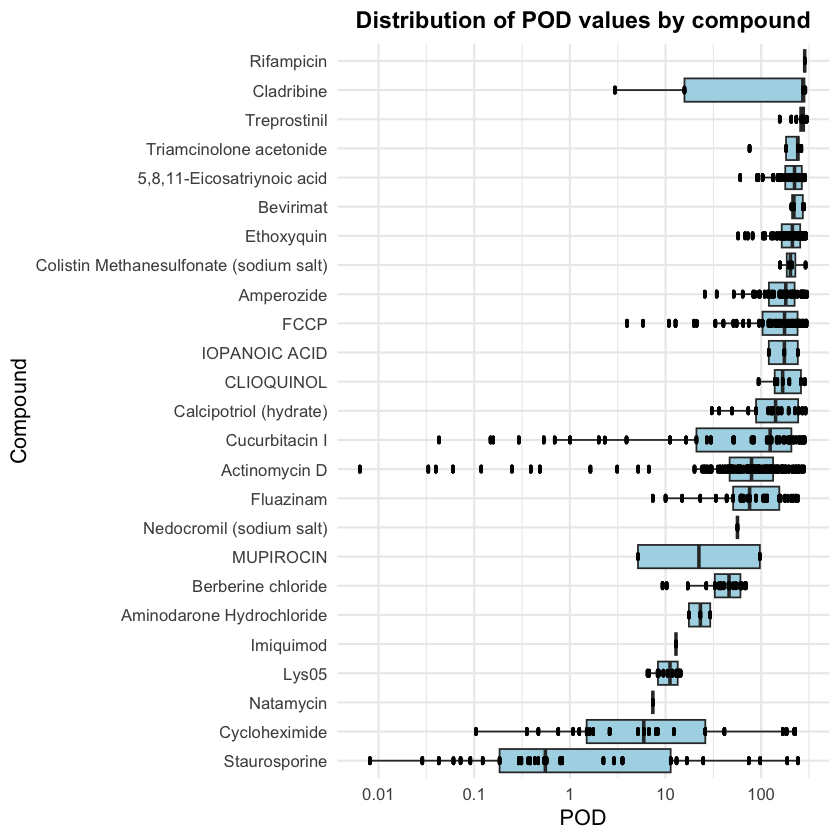

In [47]:
df_bmd <- final_df[!is.na(final_df$Concentration), ]


compound_order <- df_bmd %>%
  group_by(compound) %>%
  summarise(median_bmd = median(Concentration, na.rm = TRUE)) %>%
  arrange(median_bmd) %>%
  pull(compound)


df_bmd$compound <- factor(df_bmd$compound, levels = compound_order)


ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  labs(
    title = "Distribution of POD values by compound",
    x = "POD",
    y = "Compound"
  ) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold")
  )


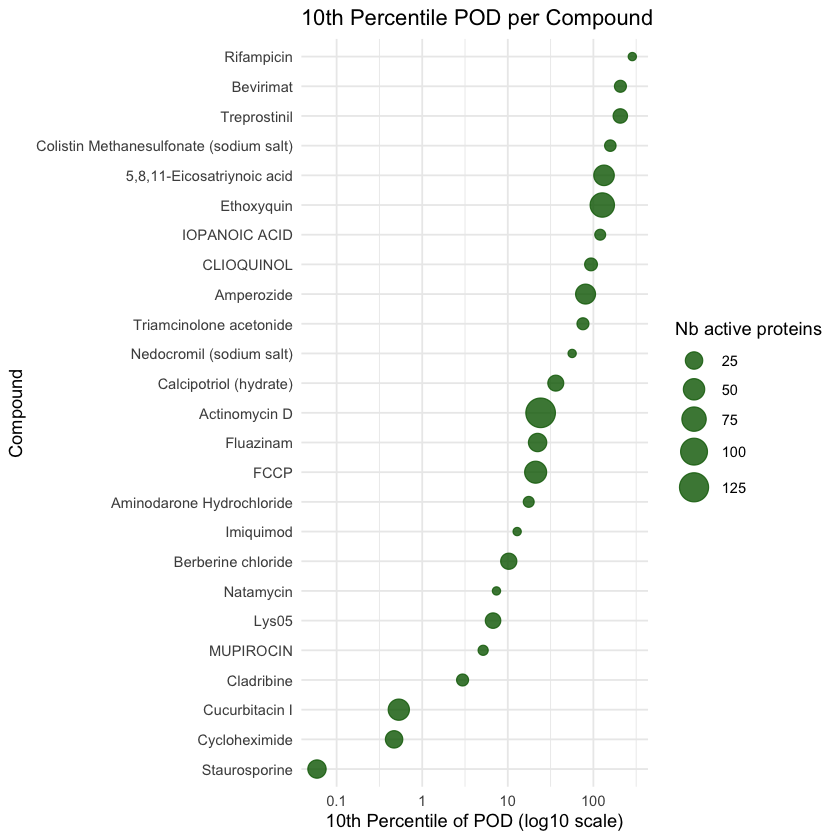

In [48]:
### Calculate the 10th percentile of BMD for each compound across all protein bmds 

compound_categories <- df_tr %>%
  select(Metadata_Compound) %>%
  distinct() %>%
  rename(compound = Metadata_Compound)

pod_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile_prot_cc= quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins_prot_cc = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound") %>%
  arrange(desc(nb_proteins_prot_cc))


#print(pod_summary, n=Inf)

ggplot(pod_summary, aes(x = pod_10th_percentile_prot_cc, y = reorder(compound, pod_10th_percentile_prot_cc))) +
  geom_point(aes(size = nb_proteins_prot_cc), color = "darkgreen", alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_size_continuous(range = c(2, 8)) +  # ajuste la taille des points ici
  labs(title = "10th Percentile POD per Compound",
       x = "10th Percentile of POD (log10 scale)",
       y = "Compound",
       size = "Nb active proteins") +
  theme_minimal()

In [49]:
final_df_prot <- read.csv("./outputs/proteomic_and_MD_10th_perc.csv", row.names = NULL)

final_df_prot<- final_df_prot %>%

  left_join(pod_summary, by = "compound")

print(head(final_df_prot))

                    compound pod_10th_percentile_MD nb_category_MD
1           5,6-benzoflavone              36.012908              8
2 5,8,11-Eicosatriynoic acid              30.884480              7
3              Actinomycin D               1.263078             13
4  Aminodarone Hydrochloride              10.978480              2
5                 Amperozide              31.605334             11
6         Berberine chloride              15.857663              4
  pod_10th_percentile nb_proteins         category pod_10th_percentile_prot_cc
1           0.3892476           2 Positive Control                          NA
2          53.5644298          33 Positive Control                   133.09848
3           0.1888817         112 Positive Control                    24.17955
4          14.7558945          11 Positive Control                    17.55542
5          45.6334129          46 Positive Control                    81.00912
6          11.6860100          23 Positive Control       

In [ ]:
#write.csv(final_df_prot, file = "./outputs/bmd_pass_3_prot_method.csv", row.names = FALSE)

Warning message:
"Removed 5 rows containing non-finite outside the scale range
(`stat_density()`)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 5 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 6 rows containing missing values"
Warning message:
"Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 2 rows containing missing values"
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_density()`)."


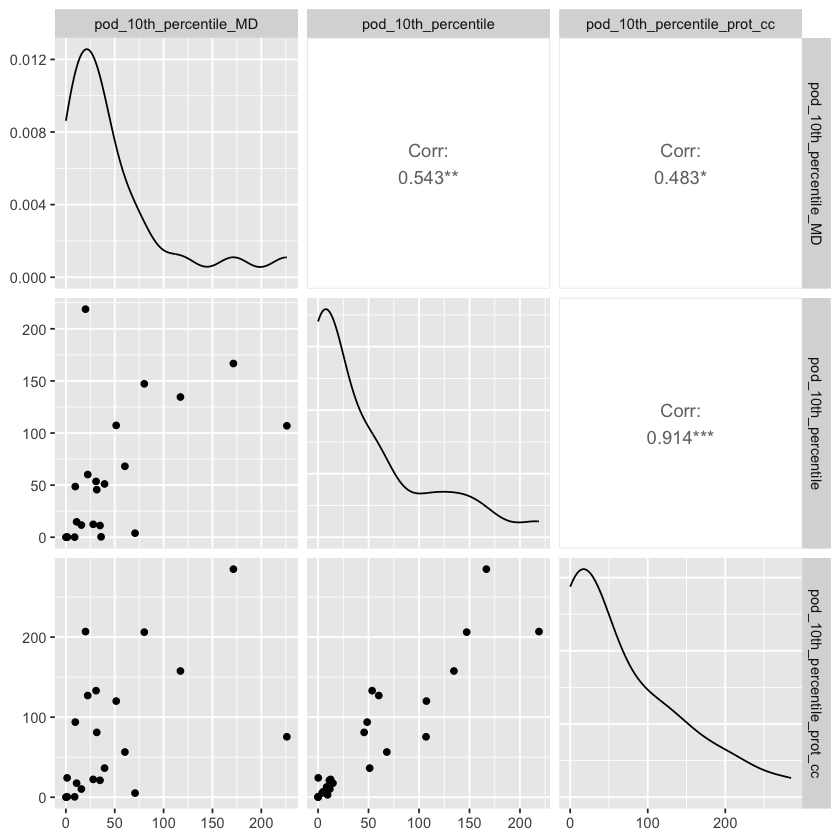

In [50]:
library(GGally)

# Sélectionne seulement les colonnes numériques que tu veux comparer
summary_df_selected <- final_df_prot %>%
  select(pod_10th_percentile_MD, pod_10th_percentile, pod_10th_percentile_prot_cc)

# Plot
ggpairs(summary_df_selected)


Warning message:
"Removed 7 rows containing missing values or values outside the scale range
(`geom_point()`)."


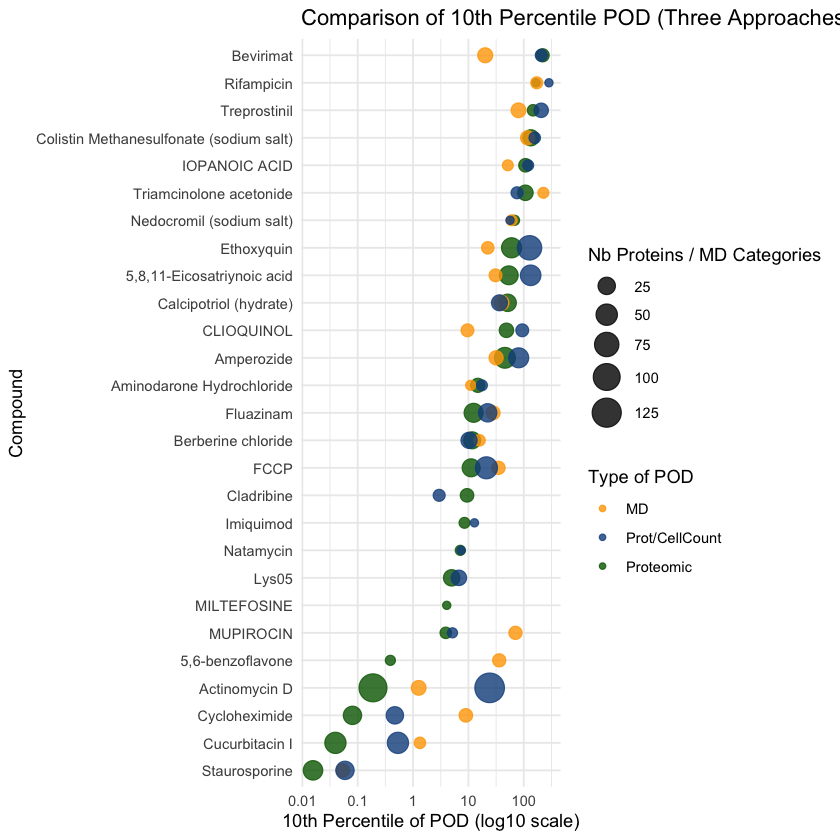

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)


df_long <- final_df_prot%>%
  pivot_longer(
    cols = c(pod_10th_percentile, pod_10th_percentile_MD, pod_10th_percentile_prot_cc),
    names_to = "type",
    values_to = "pod_10th_percentile"
  ) %>%
  mutate(
    type = recode(type,
                  "pod_10th_percentile" = "Proteomic",
                  "pod_10th_percentile_MD" = "MD",
                  "pod_10th_percentile_prot_cc" = "Prot/CellCount")
  ) %>%
  mutate(
    nb_elements = case_when(
      type == "Proteomic" ~ nb_proteins,
      type == "MD" ~ nb_category_MD,
      type == "Prot/CellCount" ~ nb_proteins_prot_cc
    )
  )


compound_order <- df_long %>%
  filter(type == "Proteomic") %>%
  arrange(pod_10th_percentile) %>%
  pull(compound)

ggplot(df_long, aes(x = pod_10th_percentile, y = factor(compound, levels = compound_order))) +
  geom_point(aes(color = type, size = nb_elements), alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100, 1000),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100", "1000")
  ) +
  scale_color_manual(values = c("Proteomic" = "darkgreen", "MD" = "orange", "Prot/CellCount" = "dodgerblue4")) +
  scale_size_continuous(range = c(2, 8)) +
  labs(
    title = "Comparison of 10th Percentile POD (Three Approaches)",
    x = "10th Percentile of POD (log10 scale)",
    y = "Compound",
    color = "Type of POD",
    size = "Nb Proteins / MD Categories"
  ) +
  theme_minimal()

The PODs calculated using the protein/cell count tend to be higher than the protein-only PODs for most compounds, though for some compounds they are lower. Despite these differences, the correlation between the two types of PODs remains strong.